In [1]:
import os.path
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50,ResNet101,ResNet152
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import backend as K
image_size = (224, 224)
batch_size = 32
save_model_flag = True
epochs = 5
print(" --------- Training --------- ")

 --------- Training --------- 


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (230, 230)

In [3]:

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/fire-vs-no-fire/Training/Training", validation_split=0.2, subset="training", seed=1337, batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True
)

validation_dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/fire-vs-no-fire/Training/Training", validation_split=0.2, subset="validation", seed=1337, shuffle=True,batch_size=BATCH_SIZE,image_size=IMG_SIZE
)


Found 39375 files belonging to 2 classes.
Using 31500 files for training.
Found 39375 files belonging to 2 classes.
Using 7875 files for validation.


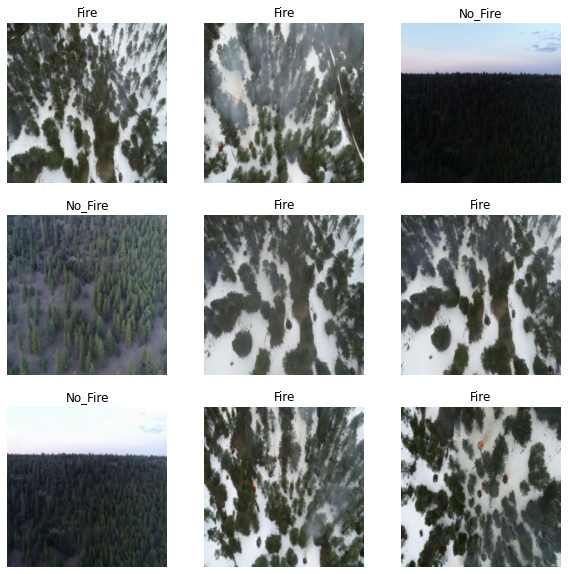

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#   tf.keras.layers.experimental.preprocessing.RandomContrast([0.2,0.2])
])

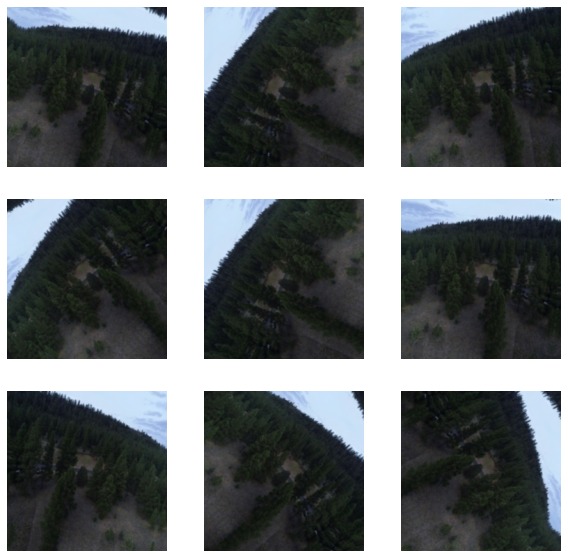

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset= -1)


In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58892288/58889256 [==============================] - 2s 0us/step


In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [11]:
base_model.trainable = False


In [12]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 230, 230, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 230, 230, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 230, 230, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 115, 115, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 115, 115, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 115, 115, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 57, 57, 128)       0     

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [14]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [15]:
inputs = tf.keras.Input(shape=(230, 230, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_model.trainable = True


In [17]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 3

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [18]:
base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 230, 230, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 230, 230, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 230, 230, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 230, 230, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0     

In [19]:
total_epochs =  13
SAVE_DIR = '/kaggle/working/saved_models/'
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/resnet101_model.h5', save_best_only=True),
]
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         callbacks=my_callbacks,
                         validation_data=validation_dataset)

Epoch 1/13
985/985 [==============================] - 355s 358ms/step - loss: 0.0966 - accuracy: 0.9615 - val_loss: 0.0224 - val_accuracy: 0.9859
Epoch 2/13
985/985 [==============================] - 191s 193ms/step - loss: 0.0142 - accuracy: 0.9950 - val_loss: 0.0073 - val_accuracy: 0.9978
Epoch 3/13
985/985 [==============================] - 191s 193ms/step - loss: 0.0084 - accuracy: 0.9966 - val_loss: 0.0075 - val_accuracy: 0.9986
Epoch 4/13
985/985 [==============================] - 191s 193ms/step - loss: 0.0070 - accuracy: 0.9975 - val_loss: 0.0059 - val_accuracy: 0.9977
Epoch 5/13
985/985 [==============================] - 190s 192ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0051 - val_accuracy: 0.9986
Epoch 6/13
985/985 [==============================] - 190s 192ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.0028 - val_accuracy: 0.9992
Epoch 8/13
985/985 [==============================] - 191s 193ms/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 0.0024 -

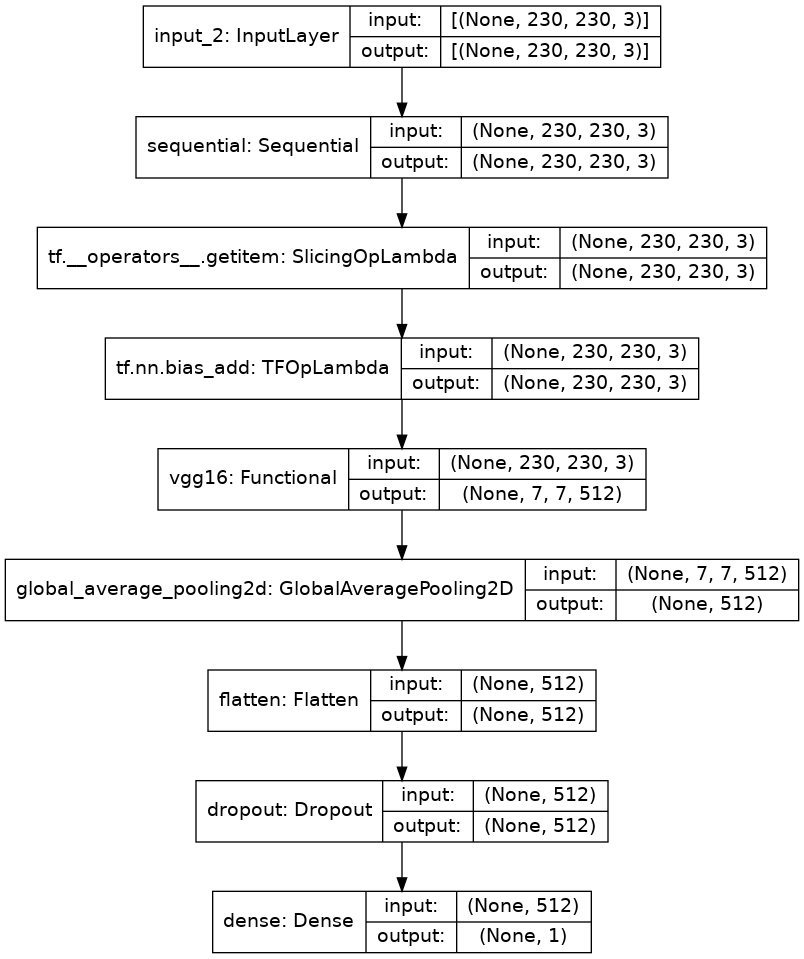

In [20]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True
)

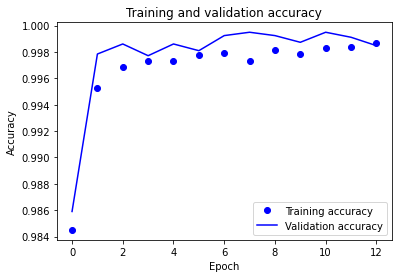

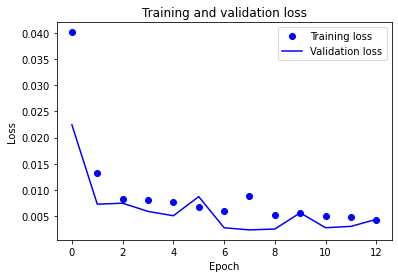

In [21]:
epochss = range(len(acc))
plt.plot(epochss, acc, 'bo', label='Training accuracy')
plt.plot(epochss, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(epochss, loss, 'bo', label='Training loss')
plt.plot(epochss, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
    

In [22]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        "../input/fire-vs-no-fire/Test/Test", seed=1337, batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True
    )

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 8617 files belonging to 2 classes.


In [23]:
test_loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

270/270 [==============================] - 71s 257ms/step - loss: 2.8554 - accuracy: 0.6821
Test accuracy : 0.6821399331092834
